# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with

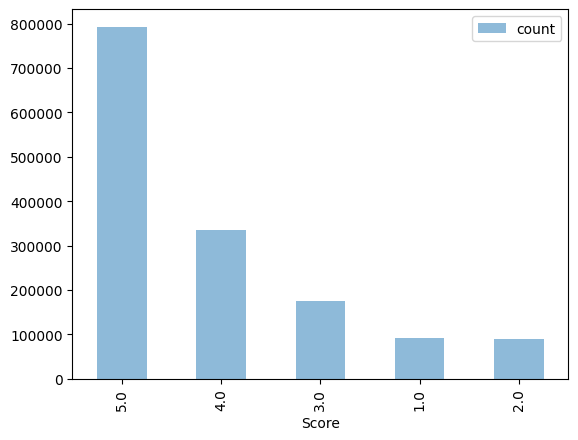

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
# Load datasets
trainingSet = pd.read_csv("/content/drive/MyDrive/train.csv")
testingSet = pd.read_csv("/content/drive/MyDrive/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print(trainingSet.head())
print(testingSet.head())
print(trainingSet.describe())

# Visualize the score distribution
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
def add_features_to(df):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # New features: text length and word count
    df['TextLength'] = df['Text'].fillna("").apply(len)
    df['WordCount'] = df['Text'].fillna("").apply(lambda x: len(x.split()))

    # Sentiment polarity
    df['Sentiment'] = df['Text'].fillna("").apply(lambda x: TextBlob(x).sentiment.polarity)

    # Extract year from timestamp
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year

    # Frequency encoding for ProductId and UserId
    df['ProductFreq'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['UserFreq'] = df.groupby('UserId')['UserId'].transform('count')

    return df

train = add_features_to(trainingSet)
# Merge datasets to generate full submission set
X_submission = pd.merge(train, testingSet, on='Id', how='inner').drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# Create training set with non-null scores
X_train = train[train['Score'].notnull()]

X_submission.to_csv("X_submission.csv", index=False)
X_train.to_csv("X_train.csv", index=False)

# Feature Selection

In [5]:
features = ['Helpfulness', 'TextLength', 'WordCount', 'Sentiment', 'Year', 'ProductFreq', 'UserFreq']

# Sample + Split into training and testing set

In [6]:
# Stratified Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train[features], X_train['Score'], test_size=0.25, stratify=X_train['Score'], random_state=42
)

# Model Creation

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimize PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Model Evaluation

KNeighborsClassifier Accuracy: 0.5139630954176272


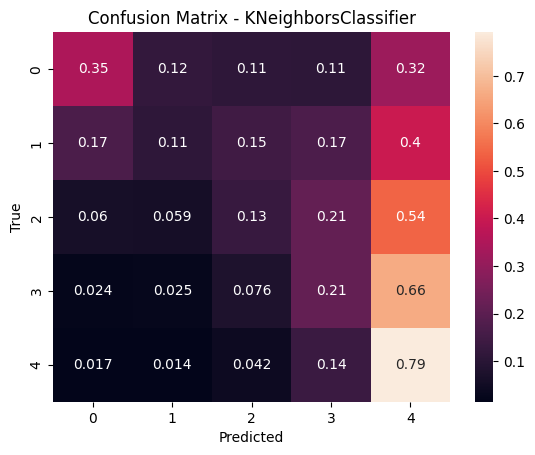

LogisticRegression Accuracy: 0.5414368658034772


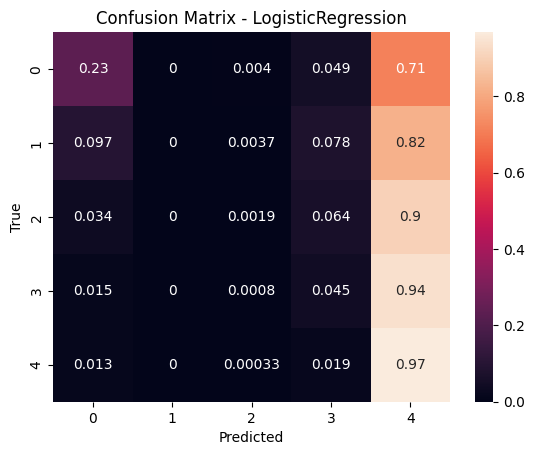

RandomForestClassifier Accuracy: 0.5531432449318138


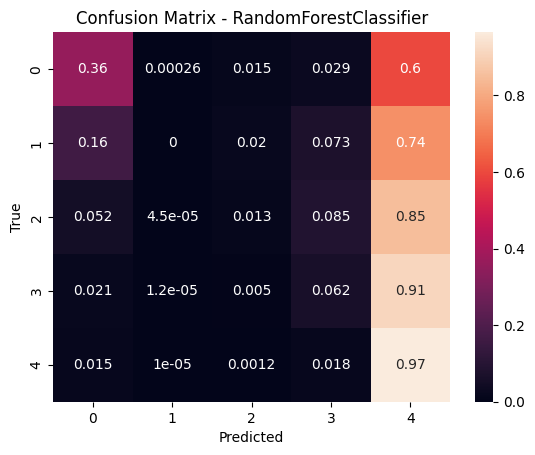

Best Model: GridSearchCV with Accuracy: 0.5531432449318138


In [10]:
def train_and_evaluate(model, model_name):
    model.fit(X_train_pca, Y_train)
    Y_test_predictions = model.predict(X_test_pca)

    accuracy = accuracy_score(Y_test, Y_test_predictions)
    print(f"{model_name} Accuracy: {accuracy}")

    cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
    sns.heatmap(cm, annot=True)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return model, accuracy

# Define models with hyperparameter tuning
models = [
    (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    (LogisticRegression(solver='liblinear', max_iter=1000), {'C': [0.1, 1, 10]}),
    (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100], 'max_depth': [5, 10, None]})
]

# Train models in parallel using GridSearchCV
best_model = None
best_accuracy = 0

for model, params in models:
    grid = GridSearchCV(model, param_grid=params, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
    model, accuracy = train_and_evaluate(grid, model.__class__.__name__)
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy
print(f"Best Model: {best_model.__class__.__name__} with Accuracy: {best_accuracy}")

# Create submission file

In [11]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Predict on the submission set using the best model
X_submission_scaled = scaler.transform(X_submission[features])
X_submission_pca = pca.transform(X_submission_scaled)
Y_submission_predictions = best_model.predict(X_submission_pca)

# Create submission file
submission = pd.DataFrame({'Id': X_submission['Id'], 'Score': Y_submission_predictions})
submission.to_csv('submission.csv', index=False)